# Данные

Данные в файле covid_flow.pkl
Данные включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

•
Многомерные временные ряды, описывающие состояние пациента (интервал неделя)

•
План лечения (препараты и процедуры) для каждого пациента

•
Исходы лечения

Процесс стационарного лечения включает в себя два подпроцесса – контролирующий и контролируемый. 

Контролирующий –
назначение препаратов и процедур. 
Контролируемый – процесс изменения состояния пациентов.

Процесс лечения
включает в себя контролирующий процесс (назначение препарат и процедур) и контролируемый
процесс (процесс изменения состояния пациентов)

_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

# Прогноза значения индикатора пациента
Прогноз проходит в следующем периоде по иформации о
текущем состоянии и предыдущих состояниях. 
Таргеты – признаки с префиксами
_dinam_fact. 
Факторы – все признаки кроме тех что с префиксами _tar. 

1) Для начала нужен литературный обзор существующих методов. 
2) Далее берешь пару существующих методов, пробуешь применить и переложить на данные. Хочется чтобы были попробованны рекурентные нейронные сети, и AutoML подход Fedot
)(https://github.com/nccr-itmo/FEDOT), но в целом ограничений на методы нет. 
3) На выходе нужен класс, который умеет принимать информацию о прошлых состояниях пациента, и
прогнозировать следующее. Читаемость и чистота кода крайне приветствуется. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.regularizers import L2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.metrics import RootMeanSquaredError
from tensorflow_addons.metrics import RSquare


In [4]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df.sort_index()


омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        

# Check the data

Divide dataset to treatment and pynamic parameters

In [5]:
stat_fact_df = df.iloc[:,0:29]
stat_fact_df = stat_fact_df.sort_values(["case", "t_point"])

But initially check if treatment strategy has been changed? No. But found 22 records with no treatments at all.

In [6]:
non_typical_treatments = []
for i in stat_fact_df.index.levels[0]:
    means = stat_fact_df.loc[(i)].mean()
    if (set(means.unique()) != set([0,1])):
        non_typical_treatments.append([i, set(means.unique())])
non_typical_treatments

[['GACAJуЭ', {0.0}],
 ['GACAKАF', {0.0}],
 ['GACALрЫ', {0.0}],
 ['GACAT&H', {0.0}],
 ['GACA^МЮ', {0.0}],
 ['GACAb!2', {0.0}],
 ['GACAjц>', {0.0}],
 ['GACAjщ[', {0.0}],
 ['GACAjюc', {0.0}],
 ['GACAjяв', {0.0}],
 ["GACAk'5", {0.0}],
 ['GACAk){', {0.0}],
 ['GACAk+ц', {0.0}],
 ['GACAk.3', {0.0}],
 ['GACAm7g', {0.0}],
 ['GACAm?о', {0.0}],
 ['GACAmBц', {0.0}],
 ['GACAmCх', {0.0}],
 ['GACAmPф', {0.0}],
 ['GACAm^и', {0.0}],
 ['GACAmnW', {0.0}],
 ['GACAmЩП', {0.0}]]

*inof_df* static information about patient and treatment

In [7]:
info_df = pd.DataFrame()
info_df["age_stat_fact"] = df["age_stat_fact"]
info_df["outcome_tar"] = df["outcome_tar"]
info_df["long_observation_tar"] = df["long_observation_tar"]
info_df["admission_date"] = df["admission_date"]
info_df["process_stages"] = df["process_stages"]
periods = info_df.groupby("case").count()["age_stat_fact"]
info_df = info_df.groupby("case").first()
info_df["periods_stat_fact"] = periods
info_df

,age_stat_fact,outcome_tar,long_observation_tar,admission_date,process_stages,periods_stat_fact
case,,,,,,
GACAAcY,81,0,22,2021-01-29,2,4
GACAAnf,73,0,6,2020-06-06,1_2,2
GACABsT,59,0,14,2020-12-30,2,3
GACACKP,71,0,15,2021-01-26,2,3
GACADBj,37,0,20,2021-02-19,2,4
...,...,...,...,...,...,...
GACBAхz,25,0,14,2020-12-25,2,3
GACBAщн,37,0,15,2021-01-14,2,3
GACBB-В,70,0,1,2020-12-22,2,1


We see that measurements are 

In [8]:
df["current_process_duration"].value_counts()

3      1992
10     1939
17     1367
24      530
31      189
38       79
45       35
52       21
59        9
66        5
73        4
80        2
185       1
178       1
143       1
171       1
164       1
157       1
150       1
101       1
136       1
129       1
122       1
115       1
108       1
94        1
87        1
192       1
Name: current_process_duration, dtype: int64

dinam_fact_df with dinamic parameters changed during observation. TARGETS!!

In [9]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

*dynam_control_df* procedures during observation. Unlike medicine, procedures has been changed during observation, so parameters pedends on time. 

In [10]:
dinam_control_df = df.iloc[:,43:47]
dinam_control_df = dinam_control_df.sort_values(["case", "t_point"])

### Data preparation 

Make some transformations. Divide observations on train and test parts. We take some part as train period and next as test period. So we have X as (, WINDOW, PARAMS) and y (PARAMS)

In [11]:
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [12]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")

Count of patients: 1992


<AxesSubplot:>

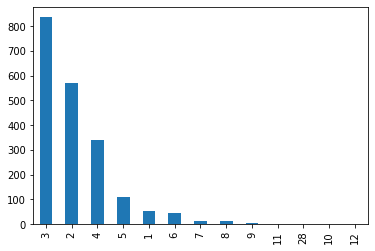

In [13]:
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

In [14]:
dinam_fact_df["Cтепень тяжести по КТ_dinam_fact"].value_counts().sort_index()

0      29
1     733
2    1250
3     696
4     195
5    3285
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

Impute NaN values using MICE methods with IterativeImputer on Linear regression as estimator 

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
df_imputed = imp.fit_transform(dinam_fact_df)
df_imputed

array([[ 36.7 ,   1.93,  27.9 , ...,   2.  , 245.  ,  14.  ],
       [ 36.3 ,   2.  ,  25.7 , ...,   2.  , 315.  ,  12.8 ],
       [ 36.6 ,   2.13,  32.  , ...,   5.  , 290.  ,  13.5 ],
       ...,
       [ 36.5 ,   1.11,  21.8 , ...,   1.  , 219.  ,  11.7 ],
       [ 36.9 ,   1.6 ,  60.8 , ...,   5.  , 335.  ,  13.4 ],
       [ 36.6 ,   3.45,  17.2 , ...,   5.  , 279.  ,  11.6 ]])

Norm data by Standart Scaler and divide and train test parts

In [16]:
scal_model = StandardScaler().fit(df_imputed)
df_scaled = scal_model.transform(df_imputed)
df_scaled

array([[ 0.29481863,  0.01592704, -0.24585399, ..., -1.04515494,
        -0.4520992 , -0.31969103],
       [-1.15370422,  0.03092487, -0.27689547, ..., -1.04515494,
        -0.05562054, -0.65881207],
       [-0.06731208,  0.05877799, -0.18800395, ...,  0.8663974 ,
        -0.19722006, -0.46099146],
       ...,
       [-0.42944279, -0.15976184, -0.33192355, ..., -1.68233905,
        -0.59936271, -0.96967302],
       [ 1.01908006, -0.05477702,  0.21835725, ...,  0.8663974 ,
         0.05765908, -0.48925155],
       [-0.06731208,  0.34159424, -0.39682846, ...,  0.8663974 ,
        -0.25952385, -0.9979331 ]])

In [17]:
df_scaled = pd.DataFrame(df_scaled, index=dinam_fact_df.index, columns=dinam_fact_df.columns)
df_scaled

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.294819               0.015927   
        1                     -1.153704               0.030925   
        2                     -0.067312               0.058778   
        3                     -0.429443               0.056635   
GACAAnf 0                      0.300794              -0.138336   
...                                 ...                    ...   
GACBB;O 0                      1.019080              -0.136194   
        1                     -0.429443              -0.044064   
GACXAAB 0                     -0.429443              -0.159762   
        1                      1.019080              -0.054777   
        2                     -0.067312               0.341594   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0             -0.245854        0.091632        1.027241   
        1             -0.276895       -0.113206       -0.087114   
        2             -0.188004       -0.065290       -0.309985   
        3             -0.258553       -0.113206       -0.309985   
GACAAnf 0             -0.347444       -1.205676        0.581499   
...                         ...             ...             ...   
GACBB;O 0             -0.324304       -1.273955       -0.309985   
        1              2.803689       -0.222816       -0.532856   
GACXAAB 0             -0.331924       -0.217121        0.094297   
        1              0.218357        0.159911       -0.755727   
        2             -0.396828        0.024789       -0.978598   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.943518   
        1                          0.399479   
        2                          0.124866   
        3                          0.263962   
GACAAnf 0                         -0.331573   
...                                     ...   
GACBB;O 0                         -1.414550   
        1                         -1.015022   
GACXAAB 0                         -0.892613   
        1                         -1.470654   
        2                         -0.076555   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       1.241817   
        1                                       0.861815   
        2                                       1.115149   
        3                                       1.368484   
GACAAnf 0                                      -0.721528   
...                                                  ...   
GACBB;O 0                                      -1.418198   
        1                                      -1.291531   
GACXAAB 0                                       0.861815   
        1                                       0.988482   
        2                                       0.481812   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                         -1.329396               2.025719   
        1                         -0.738803               0.576399   
        2                         -0.443506              -0.049444   
        3                         -1.329396               0.032904   
GACAAnf 0                         -0.335231               0.032904   
...                                     ...                    ...   
GACBB;O 0                         -0.994727               0.765799   
        1                         -0.246642               1.441050   
GACXAAB 0                         -0.345074              -0.403539   
        1                          0.343952              -0.889390   
        2                          0.442384          

In [18]:
#module divides on X [[1, 2, 3, 4]] and y [5]
WINDOW = 3
PARAMS_LENGTH = 13

def df_to_X_y(df, window = 3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_time_serie = dinam_fact_df.groupby(["case"]).size()[i]
        if (len_time_serie < window+1):
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy())
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = df_to_X_y(df_scaled, WINDOW)
X

array([[[ 0.29481863,  0.01592704, -0.24585399, ..., -1.04515494,
         -0.4520992 , -0.31969103],
        [-1.15370422,  0.03092487, -0.27689547, ..., -1.04515494,
         -0.05562054, -0.65881207],
        [-0.06731208,  0.05877799, -0.18800395, ...,  0.8663974 ,
         -0.19722006, -0.46099146]],

       [[-0.06731208, -0.16404694,  2.54082442, ..., -0.40797082,
          1.98341257, -1.19575371],
        [-0.79157351,  0.12733951, -0.30088207, ...,  0.8663974 ,
         -0.21987599, -0.9979331 ],
        [-0.79157351, -0.09977052, -0.31358086, ...,  0.8663974 ,
          0.09730694, -0.82837258]],

       [[-0.79157351, -0.16618948, -0.48571998, ..., -0.40797082,
          0.02367519, -0.54577172],
        [-0.79157351, -0.12548108, -0.2571418 , ...,  0.8663974 ,
         -0.27085182, -0.43273137],
        [ 0.65694934, -0.10405561, -0.4067053 , ...,  0.8663974 ,
         -0.55405086, -0.15013051]],

       ...,

       [[ 2.82973362, -0.13619382, -0.13861978, ..., -1.6823390

Divide on test and train splits and delete last element to divide samples on batches

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = X_train[:-4], y_train[:-4]
X_test, y_test = X_test[:-10], y_test[:-10]
print(X_train.shape)
print(y_test.shape)

(420, 3, 13)
(96, 13)


### Training

In [20]:
#function with results 
def show_results(X_test, y_test, model, history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.legend(["train loss", "validation loss", "validation root_mean_squared_error"])
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    r2_stat = r2_score(y_pred, y_test, multioutput="raw_values")
    predicted_values = scal_model.inverse_transform(y_pred)
    real_values = scal_model.inverse_transform(y_test)
    last_values = []
    last_values.extend(scal_model.inverse_transform(X_test[0]))
    stat=[]
    stat.extend(last_values)
    stat.append(real_values[0])
    stat.append(predicted_values[0])
    stat.append(r2_stat)
    df = pd.DataFrame(stat, index=[*["prev"]*len(last_values), "real", "predicted", "R2"])
    print("Parameters on test datasets: \n")
    display(df)
    print(list(zip(model.metrics_names, model.evaluate(X_test, y_test, batch_size=BATCH_SIZE))))
    

### One layer RNN size 13

1. Simple RNN with state units 13 and batch size 1

In [21]:
BATCH_SIZE=1

model = Sequential(name="RNN13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(SimpleRNN(PARAMS_LENGTH, activation="relu", return_sequences=False))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_simple_rnn_13.summary()

Model: "RNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1, 13)                   351       
                                                                 
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________


Lets show learning history for the model. We see intersection on 15 epochs - model becomes overfit.

In [22]:
history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=10, validation_split=0.1, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_simple_rnn_13.save("RNN13")

INFO:tensorflow:Assets written to: RNN13\assets


Lets show on table what we have predicted:

Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,36.400000,0.650000,50.620000,72.000000,22.000000,3.400000,8.100000,0.173000,5.300000,0.000000,2.000000,351.660000,13.900000
prev,36.500000,0.920000,62.630000,91.000000,14.000000,7.300000,8.100000,0.193000,8.800000,0.000000,2.000000,258.180000,14.900000
prev,36.100000,1.470000,23.680000,69.000000,18.000000,6.650000,3.800000,0.257000,21.000000,0.000000,5.000000,283.240000,6.400000
real,36.300000,2.367587,30.177622,72.000000,16.000000,10.365380,9.367001,0.263087,24.539463,0.000000,5.000000,276.381040,14.977715
predicted,36.618587,1.855663,45.324387,72.657982,19.390871,9.750290,9.239248,0.239672,23.700424,0.117809,6.281120,348.802795,15.131246
R2,-189.426578,-1.146884,-353.422942,-33.067953,-892.092847,-7.043127,-3.940776,-40.103332,-4.245077,0.736124,-3.955739,-89.970961,-14.686236


96/96 [==============================] - 1s 5ms/step - loss: 1.7632 - root_mean_squared_error: 1.3279
[('loss', 1.7632160186767578), ('root_mean_squared_error', 1.3278613090515137)]


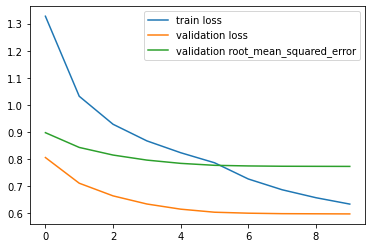

In [23]:
show_results(X_test, y_test, model_simple_rnn_13, history)

### LSTM with 13 units and batch 1

In [24]:
BATCH_SIZE=1

model = Sequential(name="LSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13 = model
model_lstm_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13.summary()

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 13)                   1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model_lstm_13.fit(X_train, y_train,
 epochs=30, validation_split=3/35, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13")


INFO:tensorflow:Assets written to: LSTM13\assets


INFO:tensorflow:Assets written to: LSTM13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,36.400000,0.650000,50.620000,72.000000,22.000000,3.400000,8.100000,0.173000,5.300000,0.000000,2.000000,351.660000,13.900000
prev,36.500000,0.920000,62.630000,91.000000,14.000000,7.300000,8.100000,0.193000,8.800000,0.000000,2.000000,258.180000,14.900000
prev,36.100000,1.470000,23.680000,69.000000,18.000000,6.650000,3.800000,0.257000,21.000000,0.000000,5.000000,283.240000,6.400000
real,36.300000,2.367587,30.177622,72.000000,16.000000,10.365380,9.367001,0.263087,24.539463,0.000000,5.000000,276.381040,14.977715
predicted,36.642632,1.815829,32.599293,82.133064,17.741915,8.422578,7.964018,0.214125,21.054871,0.013311,4.364670,287.007355,11.927969
R2,-16.701470,-1.467289,-141.475233,-10.755092,-4.014174,-16.102093,-0.287506,-3.998185,-2.076091,-3.280479,-20.605151,-50.718795,-0.259115


96/96 [==============================] - 1s 5ms/step - loss: 1.6132 - root_mean_squared_error: 1.2701
[('loss', 1.6132324934005737), ('root_mean_squared_error', 1.2701308727264404)]


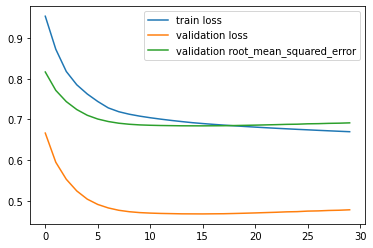

In [26]:
show_results(X_test, y_test, model_lstm_13, history)

### LSTM13 with batch 12

In [27]:
BATCH_SIZE=12

model = Sequential(name="LSTM13Batch12")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13_b12.summary()

Model: "LSTM13Batch12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (12, 13)                  1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=30, validation_split=3/35, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13Batch12")

INFO:tensorflow:Assets written to: LSTM13Batch12\assets


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,36.400000,0.650000,50.620000,72.000000,22.000000,3.400000,8.100000,0.173000,5.300000,0.000000,2.000000,351.660000,13.900000
prev,36.500000,0.920000,62.630000,91.000000,14.000000,7.300000,8.100000,0.193000,8.800000,0.000000,2.000000,258.180000,14.900000
prev,36.100000,1.470000,23.680000,69.000000,18.000000,6.650000,3.800000,0.257000,21.000000,0.000000,5.000000,283.240000,6.400000
real,36.300000,2.367587,30.177622,72.000000,16.000000,10.365380,9.367001,0.263087,24.539463,0.000000,5.000000,276.381040,14.977715
predicted,36.597469,1.836909,28.884399,79.158333,16.356565,7.635711,8.134977,0.205477,27.747868,-0.045852,3.854692,254.752121,12.347164
R2,-26.620417,-3.893690,-156.759398,-32.046771,-5.535006,-25.865940,-0.939066,-4.854315,-3.814668,-4.351739,-50.529754,-64.751314,-0.652774


8/8 [==============================] - 0s 5ms/step - loss: 1.6322 - root_mean_squared_error: 1.2776
[('loss', 1.6321741342544556), ('root_mean_squared_error', 1.2775657176971436)]


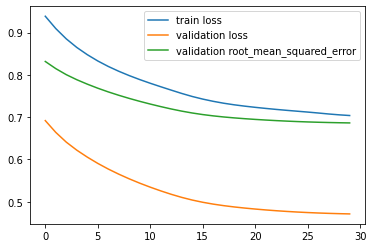

In [29]:
show_results(X_test, y_test, model_lstm_13_b12, history)

### LSTM64 Encoder + LSTM 13 Decoder 

In [30]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_64 = model
model_lstm_64.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_64.summary()

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (12, 3, 64)               19968     
                                                                 
 lstm_3 (LSTM)               (12, 13)                  4056      
                                                                 
Total params: 24,024
Trainable params: 24,024
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model_lstm_64.fit(X_train, y_train,
 epochs=30, validation_split=3/35, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xLSTM13")

INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,36.400000,0.650000,50.620000,72.000000,22.000000,3.400000,8.100000,0.173000,5.300000,0.000000,2.000000,351.660000,13.900000
prev,36.500000,0.920000,62.630000,91.000000,14.000000,7.300000,8.100000,0.193000,8.800000,0.000000,2.000000,258.180000,14.900000
prev,36.100000,1.470000,23.680000,69.000000,18.000000,6.650000,3.800000,0.257000,21.000000,0.000000,5.000000,283.240000,6.400000
real,36.300000,2.367587,30.177622,72.000000,16.000000,10.365380,9.367001,0.263087,24.539463,0.000000,5.000000,276.381040,14.977715
predicted,36.603630,1.847778,25.856173,82.901436,17.767754,7.764771,7.939318,0.197705,21.387161,0.044766,4.557021,267.195496,12.435115
R2,-22.458351,-2.428196,-115.434096,-6.545096,-3.448664,-13.205348,-0.320036,-3.202733,-1.468125,-3.222679,-21.255021,-48.568751,-0.064479


8/8 [==============================] - 0s 2ms/step - loss: 1.6306 - root_mean_squared_error: 1.2769
[('loss', 1.6305915117263794), ('root_mean_squared_error', 1.2769461870193481)]


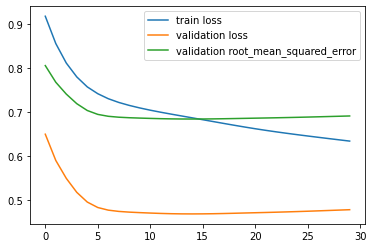

In [32]:
show_results(X_test, y_test, model_lstm_64, history)

## LSTM64+Dense13

In [33]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xDense13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_dense = model
model_lstm_dense.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_dense.summary()

Model: "LSTM64xDense13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (12, 64)                  19968     
                                                                 
 dense (Dense)               (12, 13)                  845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model_lstm_dense.fit(X_train, y_train,
 epochs=30, validation_split=3/35, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xDense13")

INFO:tensorflow:Assets written to: LSTM64xDense13\assets


INFO:tensorflow:Assets written to: LSTM64xDense13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,36.400000,0.650000,50.620000,72.000000,22.000000,3.400000,8.100000,0.173000,5.300000,0.000000,2.000000,351.660000,13.900000
prev,36.500000,0.920000,62.630000,91.000000,14.000000,7.300000,8.100000,0.193000,8.800000,0.000000,2.000000,258.180000,14.900000
prev,36.100000,1.470000,23.680000,69.000000,18.000000,6.650000,3.800000,0.257000,21.000000,0.000000,5.000000,283.240000,6.400000
real,36.300000,2.367587,30.177622,72.000000,16.000000,10.365380,9.367001,0.263087,24.539463,0.000000,5.000000,276.381040,14.977715
predicted,36.547710,1.847880,40.394718,83.118477,17.521315,7.693678,7.734874,0.219676,23.668505,-0.042552,4.753182,300.205566,12.605657
R2,-12.667052,-0.955955,-62.273657,-7.180486,-2.493740,-4.410285,0.147903,-1.718883,-1.156833,0.919442,-8.998881,-33.021074,0.164318


8/8 [==============================] - 0s 10ms/step - loss: 1.5449 - root_mean_squared_error: 1.2429
[('loss', 1.5448578596115112), ('root_mean_squared_error', 1.2429231405258179)]


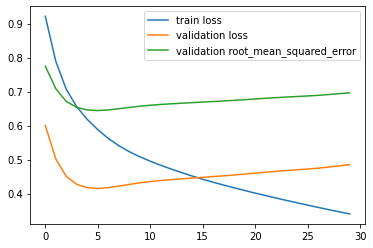

In [35]:
show_results(X_test, y_test, model_lstm_dense, history)

### Lets add static parameters as additional inputs to fully connected layer

In [36]:
info_df_train = info_df["age_stat_fact"]
info_df_train = StandardScaler().fit_transform(info_df_train)
medicine_df_train = df.iloc[:, :29]
dinam_control_df

TypeError: 'StandardScaler' object is not callable

In [ ]:
BATCH_SIZE = 12
input_static = Input((1))
input_dinamic = Input((3, 13), batch_size=BATCH_SIZE)
dl = Dense()
 

NameError: name 'Input' is not defined

Lets delete unnecessary parameters from info dataframe